In [1]:
import serial
import sys
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.transform import Rotation as R

import math

def haversine(lat1, lon1, lat2, lon2):
      R = 6372.8 #km
      dLat = math.radians(lat2 - lat1)
      dLon = math.radians(lon2 - lon1)
      lat1 = math.radians(lat1)
      lat2 = math.radians(lat2)
      a = math.sin(dLat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dLon/2)**2
      c = 2*math.asin(math.sqrt(a))
      return R * c

def bearing(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    Bearing = math.atan2(math.sin(dlon)*math.cos(lat2), 
                         math.cos(lat1)*math.sin(lat2)-math.sin(lat1)*math.cos(lat2)*math.cos(dlon))

    return Bearing

def get_serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

def extract_lon(l):
    l = str(l)
    # print("lon: ", l)
    return -float(l[:3]) - float(l[3:])/60.0 

def extract_lat(l):
    l = str(l)
    # print("lat: ", l)
    return float(l[:2]) + float(l[2:])/60.0 

In [2]:
print(get_serial_ports())

['/dev/ttyUSB0', '/dev/ttyACM1', '/dev/ttyACM0', '/dev/ttyTHS4', '/dev/ttyTHS1']


In [3]:

def test_port(s_port, baud=115200):
    ser = serial.Serial()
    ser_open = False
    attempts = 0

    #attempt to connect
    while not ser_open and attempts < 5:
        try:
            ser = serial.Serial(s_port, baud, timeout=3)
            print("opened ", s_port, " succesfully")
            print(ser.read(10))
            ser_open = True
        except:
            print("Failed to open ", port, " serial port: ", attempts)
            
        if not ser_open:
            time.sleep(0.5)
            attempts += 1

    if ser_open:
        ser.close()



ports = get_serial_ports()

for port in ports:
    test_port(port)
    


opened  /dev/ttyUSB0  succesfully
b'Artemis Op'
opened  /dev/ttyACM1  succesfully
b'$GNGGA,000'
opened  /dev/ttyACM0  succesfully
b', 1488\r\n14'
opened  /dev/ttyTHS4  succesfully
b''
opened  /dev/ttyTHS1  succesfully
b''


In [4]:
class Serial_Interface:
    def __init__(self, name, cols, types, proc_string_fun, s_port='/dev/ttyACM0', baud=115200):
        self.name = name
        self.cols = cols
        self.types = types
        self.df = pd.DataFrame(columns=cols)
        self.ser = serial.Serial()
        ser_open = False
        attempts = 0
        self.process_strings_fun = proc_string_fun

        #attempt to connect
        while not ser_open and attempts < 5:
            try:
                self.ser = serial.Serial(s_port, baud, timeout=None)
                ser_open = True
            except:
                print("Failed to open ", name, " serial port at: ", s_port, " in ", attempts, " attempts")
                
            if not ser_open:
                time.sleep(0.5)
                attempts += 1
                
    def check_and_log(self, c_time):
        if self.ser.in_waiting:
            bytes =self.ser.readline()
            # print("gps: ", gps_bytes)
            try:
                decoded_strings = str(bytes[0:len(bytes)-2].decode("utf-8")).split(',')
                # print(decoded_strings[0])
                out_success, out = self.process_strings_fun(decoded_strings, self.types)
                if out_success:
                    self.df.loc[len(self.df)] = out
                    
            except:
                print(self.name, " had a logging error")
                
    def close_and_save(self):
        self.ser.close()
        
    def flush_logs(self):
        self.ser.flushInput()
        self.df = pd.DataFrame(columns=self.cols)
        



In [5]:
gps_cols = ['Wall_Time',
    'header',
    'utc time',
    'Lat',
    'Lat_Dir',
    'Lon',
    'Lon _Dir',
    'Quality_Indicator',
    'Satellites Used',
    'HDOP',
    'Altitude',
    'Alt_units',
    'Geoidal_Separation',
    'GS_units',
    'DGPS_Station_ID',
    'checksum']

gps_types = [str, # header
        float, # utc time
        str, # lat
        str, # lat dir
        str, # lon
        str, # lon dir
        int, # quality indicator
        int, # N satellites
        float, # hdop
        float, # altitude
        str, # alt units
        float, #geoidal separation
        str, # gs units
        str, # dpgs station id
        str] # check sum

def gps_proc_string(decoded_strings, c_time, gps_types):
    if decoded_strings[0] == '$GNGGA':
        # print(decoded_gps_strings)
        out = [ty(st) for st, ty in zip(decoded_strings, gps_types)]
        out[2] = extract_lat(out[2])
        out[4] = extract_lon(out[4])
        out.insert(0, c_time)
        # print("gps_out: ", out)
        return True, out
    return False, []

# gps_log = Serial_Interface("GPS", gps_cols, gps_types, gps_proc_string)
# gps_log.flush_logs()

# start = time.time()
# max_time = 10.0
# c_time = time.time() - start
# while c_time < max_time:
#     c_time = time.time() - start
#     gps_log.check_and_log(c_time)

# gps_log.close_and_save()
# gps_log.df.head()

GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error


,Wall_Time,header,utc time,Lat,Lat_Dir,Lon,Lon _Dir,Quality_Indicator,Satellites Used,HDOP,Altitude,Alt_units,Geoidal_Separation,GS_units,DGPS_Station_ID,checksum


In [6]:
ola_cols = ['Wall_Time',
        'rtcDate',
        'rtcTime',
        'Q9_1',
        'Q9_2',
        'Q9_3',
        'HeadAcc',
        'RawAX',
        'RawAY',
        'RawAZ',
        'RawGX',
        'RawGY',
        'RawGZ',
        'RawMX',
        'RawMY',
        'RawMZ',
        'output_Hz']

ola_types = [str, # rtcDate - 01/01/2000
        str, # rtcTime - 07:24:04.91
        float, # q1
        float, # q2
        float, # q3
        float, # head acc
        float, # raw ax 
        float, # raw ay
        float, # raw az
        float, # raw gx
        float, # raw gy
        float, # raw gz
        float, # raw mx  
        float, # raw my
        float, # raw mz 
        float] # output_Hz

def ola_proc_string(decoded_strings, ola_types):
    if decoded_strings[0] == '01/01/2000':
        out = [ty(st) for st, ty in zip(decoded_strings, ola_types)]
        out.insert(0, c_time)
        # print("ola_out: ", out)
        return True, out
    return False, []


# ola_log = Serial_Interface("OLA", ola_cols, ola_types, ola_proc_string, s_port='/dev/ttyUSB0')
# ola_log.flush_logs()

# start = time.time()
# max_time = 10.0
# c_time = time.time() - start
# while c_time < max_time:
#     c_time = time.time() - start
#     ola_log.check_and_log(c_time)

# ola_log.close_and_save()
# ola_log.df.head()


OLA  had a logging error


,Wall_Time,rtcDate,rtcTime,Q9_1,Q9_2,Q9_3,HeadAcc,RawAX,RawAY,RawAZ,RawGX,RawGY,RawGZ,RawMX,RawMY,RawMZ,output_Hz
0,2.963105,01/01/2000,21:53:04.84,-0.00471,0.00012,0.00164,355.0,-40.0,-230.0,-8124.0,-8.0,-1.0,10.0,-183.0,-413.0,294.0,16.667
1,2.998799,01/01/2000,21:53:04.92,-0.00490,0.00013,0.00172,355.0,-46.0,-230.0,-8148.0,-13.0,0.0,9.0,-188.0,-421.0,294.0,22.222
2,3.022938,01/01/2000,21:53:04.94,-0.00509,0.00015,0.00180,355.0,-22.0,-288.0,-8122.0,-11.0,2.0,8.0,-191.0,-416.0,306.0,30.000
3,3.047248,01/01/2000,21:53:04.95,-0.00531,0.00016,0.00186,355.0,-22.0,-296.0,-8142.0,-14.0,0.0,7.0,-178.0,-418.0,296.0,36.364
4,3.070385,01/01/2000,21:53:04.96,-0.00531,0.00016,0.00186,355.0,-22.0,-296.0,-8142.0,-14.0,0.0,7.0,-178.0,-418.0,296.0,41.667


In [7]:
pwm_cols = ['Wall_Time',
        'Steer',
        'Throttle']

pwm_types = [float, # steer
                float] # throttle
    
def pwm_proc_string(decoded_strings, pwm_types):
    out = [ty(st) for st, ty in zip(decoded_strings, pwm_types)]
    out.insert(0, c_time)
    return True, out
        
pwm_log = Serial_Interface("PWM", pwm_cols, pwm_types, pwm_proc_string, s_port='/dev/ttyACM1')
pwm_log.flush_logs()

start = time.time()
max_time = 10.0
c_time = time.time() - start
while c_time < max_time:
    c_time = time.time() - start
    pwm_log.check_and_log(c_time)

pwm_log.close_and_save()
pwm_log.df.head()


PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error
PWM  had a logging error


,Wall_Time,Steer,Throttle


In [10]:
ports = get_serial_ports()

for port in ports:
    test_port(port)
    

opened  /dev/ttyUSB0  succesfully
b'Artemis Op'
opened  /dev/ttyACM1  succesfully
b'$GNGGA,001'
opened  /dev/ttyACM0  succesfully
b', 1488\r\n14'
opened  /dev/ttyTHS4  succesfully
b''
opened  /dev/ttyTHS1  succesfully
b''


In [11]:
ola_log = Serial_Interface("OLA", ola_cols, ola_types, ola_proc_string, s_port='/dev/ttyUSB0')
gps_log = Serial_Interface("GPS", gps_cols, gps_types, gps_proc_string, s_port='/dev/ttyACM1')
pwm_log = Serial_Interface("PWM", pwm_cols, pwm_types, pwm_proc_string, s_port='/dev/ttyACM0')

ola_log.flush_logs()
gps_log.flush_logs()
pwm_log.flush_logs()


start = time.time()
max_time = 20.0
c_time = 0.0
cnt = 0
while c_time < max_time:
    cnt += 1
    c_time = time.time() - start
    ola_log.check_and_log(c_time)
    gps_log.check_and_log(c_time)
    pwm_log.check_and_log(c_time)

print("counter: ", cnt, " = ", cnt / max_time, " Hz")

ola_log.close_and_save()
gps_log.close_and_save()
pwm_log.close_and_save()


PWM  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error
GPS  had a logging error


In [9]:
m_lon = gps_log.df["Lon"].mean()
m_lat = gps_log.df["Lat"].mean()

gps_log.df["dist2center"] = gps_log.df.apply(lambda x: 1000.0 * haversine(x["Lat"], x["Lon"], m_lat, m_lon), axis=1)
gps_log.df["bearing2center"] = gps_log.df.apply(lambda x: bearing(m_lat, m_lon, x["Lat"], x["Lon"]), axis=1)
gps_log.df["x"] = gps_log.df.apply(lambda x: math.sin(x["bearing2center"]) * x["dist2center"], axis=1)
gps_log.df["y"] = gps_log.df.apply(lambda x: math.cos(x["bearing2center"]) * x["dist2center"], axis=1)
display(gps_log.df.head())

ValueError: Wrong number of items passed 16, placement implies 1

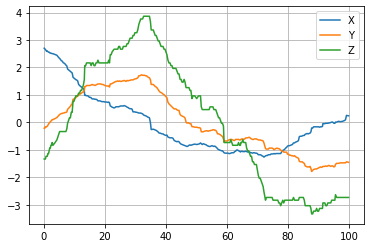

In [ ]:
# display(df)

plt.plot(gps_log.df.Wall_Time, gps_log.df.x, label='X')
plt.plot(gps_log.df.Wall_Time, gps_log.df.y, label='Y')
plt.plot(gps_log.df.Wall_Time, gps_log.df.Altitude - gps_log.df["Altitude"].mean(), label='Z')
plt.grid()
plt.legend()
plt.show()

,Wall_Time,rtcDate,rtcTime,Q9_1,Q9_2,Q9_3,HeadAcc,RawAX,RawAY,RawAZ,RawGX,RawGY,RawGZ,RawMX,RawMY,RawMZ,output_Hz,Yaw,Pitch,Roll
0,2.797943,01/01/2000,01:37:27.61,-0.00440,-0.00053,0.00173,327.0,24.0,-190.0,-8110.0,-14.0,-3.0,5.0,-110.0,-271.0,622.0,16.667,0.197974,-0.061605,-0.504099
1,2.858054,01/01/2000,01:37:27.69,-0.00480,-0.00065,0.00187,327.0,14.0,-196.0,-8124.0,-13.0,-7.0,6.0,-110.0,-278.0,627.0,22.222,0.213926,-0.075512,-0.549902
2,2.904006,01/01/2000,01:37:27.71,-0.00494,-0.00067,0.00195,327.0,40.0,-206.0,-8132.0,-8.0,-1.0,8.0,-115.0,-281.0,614.0,30.000,0.223072,-0.077879,-0.565934
3,2.951149,01/01/2000,01:37:27.72,-0.00494,-0.00067,0.00195,327.0,40.0,-206.0,-8132.0,-8.0,-1.0,8.0,-115.0,-281.0,614.0,36.364,0.223072,-0.077879,-0.565934
4,3.082705,01/01/2000,01:37:27.73,-0.00512,-0.00072,0.00198,327.0,14.0,-200.0,-8164.0,-12.0,-5.0,3.0,-110.0,-271.0,614.0,41.667,0.226466,-0.083666,-0.586547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,99.910395,01/01/2000,01:38:12.74,-0.99304,-0.11700,0.00176,300.0,-12.0,-206.0,-8140.0,-13.0,-4.0,9.0,-110.0,-278.0,619.0,87.414,-13.434247,-0.379887,-178.498974
3945,99.932528,01/01/2000,01:38:12.75,-0.99304,-0.11700,0.00176,300.0,-12.0,-206.0,-8140.0,-13.0,-4.0,9.0,-110.0,-278.0,619.0,87.417,-13.434247,-0.379887,-178.498974
3946,99.954412,01/01/2000,01:38:12.76,-0.99304,-0.11700,0.00176,300.0,18.0,-224.0,-8124.0,-12.0,-3.0,10.0,-111.0,-269.0,616.0,87.400,-13.434247,-0.379887,-178.498974
3947,99.977749,01/01/2000,01:38:12.78,-0.99304,-0.11700,0.00175,300.0,14.0,-196.0,-8130.0,-16.0,-4.0,5.0,-110.0,-268.0,617.0,87.403,-13.434261,-0.378767,-178.498691


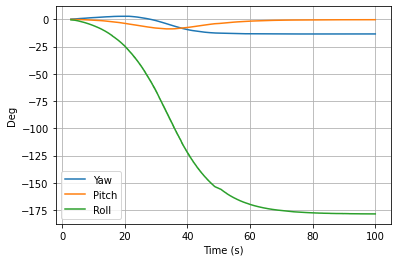

In [ ]:
yaws = []
pitches = []
rolls = []
for row in ola_log.df.itertuples():
    qx = row.Q9_1
    qy = row.Q9_2
    qz = row.Q9_3
    qw = math.sqrt( 1.0 - (qx**2 + qy**2 + qz**2))
    
    r = R.from_quat([qx, qy, qz, qw])
    ypr = r.as_euler('zyx', degrees=True)
    
    yaws.append(ypr[0])
    pitches.append(ypr[1])
    rolls.append(ypr[2])
    
ola_log.df['Yaw'] = yaws
ola_log.df['Pitch'] = pitches
ola_log.df['Roll'] = rolls

display(ola_log.df)

plt.plot(ola_log.df.Wall_Time, ola_log.df.Yaw, label='Yaw')
plt.plot(ola_log.df.Wall_Time, ola_log.df.Pitch, label='Pitch')
plt.plot(ola_log.df.Wall_Time, ola_log.df.Roll, label='Roll')
plt.xlabel('Time (s)')
plt.ylabel('Deg')
plt.grid()
plt.legend()
plt.show()